In [3]:
# api key
# @@@@



# get함수
# 다중회사 주요계정 개발 가이드 (회사 재무표)
#     - https://opendart.fss.or.kr/api/fnlttMultiAcnt.json

# 고유번호 개발 가이드 (회사코드 찾기)
#     - https://opendart.fss.or.kr/api/corpCode.json

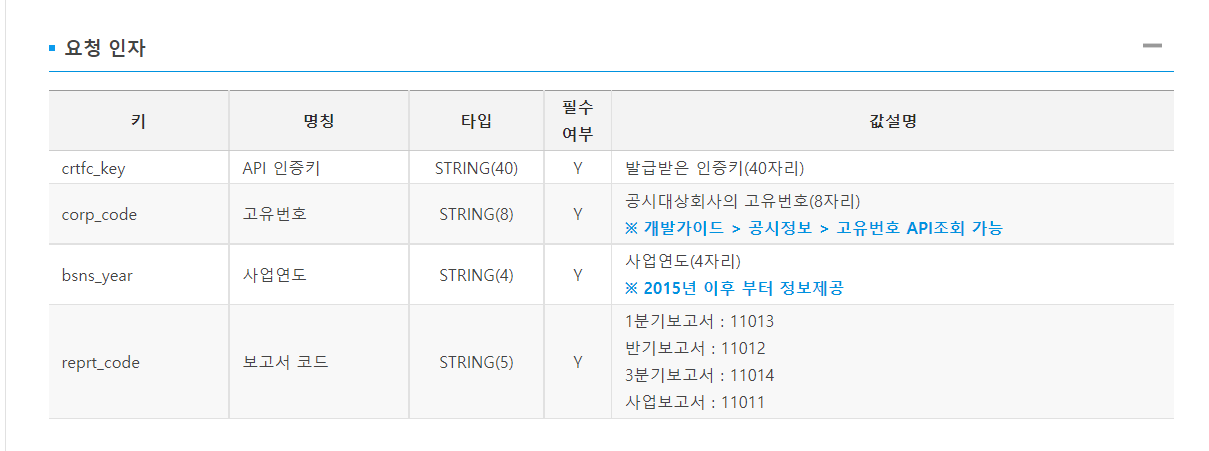

In [3]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [6]:
df_corpcode

,종목명,종목코드,기업코드,수정일
0,지놈앤컴퍼니,314130,01276026,20210216
1,웹젠,069080,00405320,20210215
2,우리넷,115440,00664048,20210217
3,마이크로디지탈,305090,01267967,20210217
4,나노,187790,00994994,20210216
...,...,...,...,...
1970,컨버즈,109070,00753643,20210513
1971,텔라움,047730,00304401,20210506
1972,뉴파워프라즈마,144960,00521390,20210602
1973,에이디테크놀로지,200710,00657002,20210602


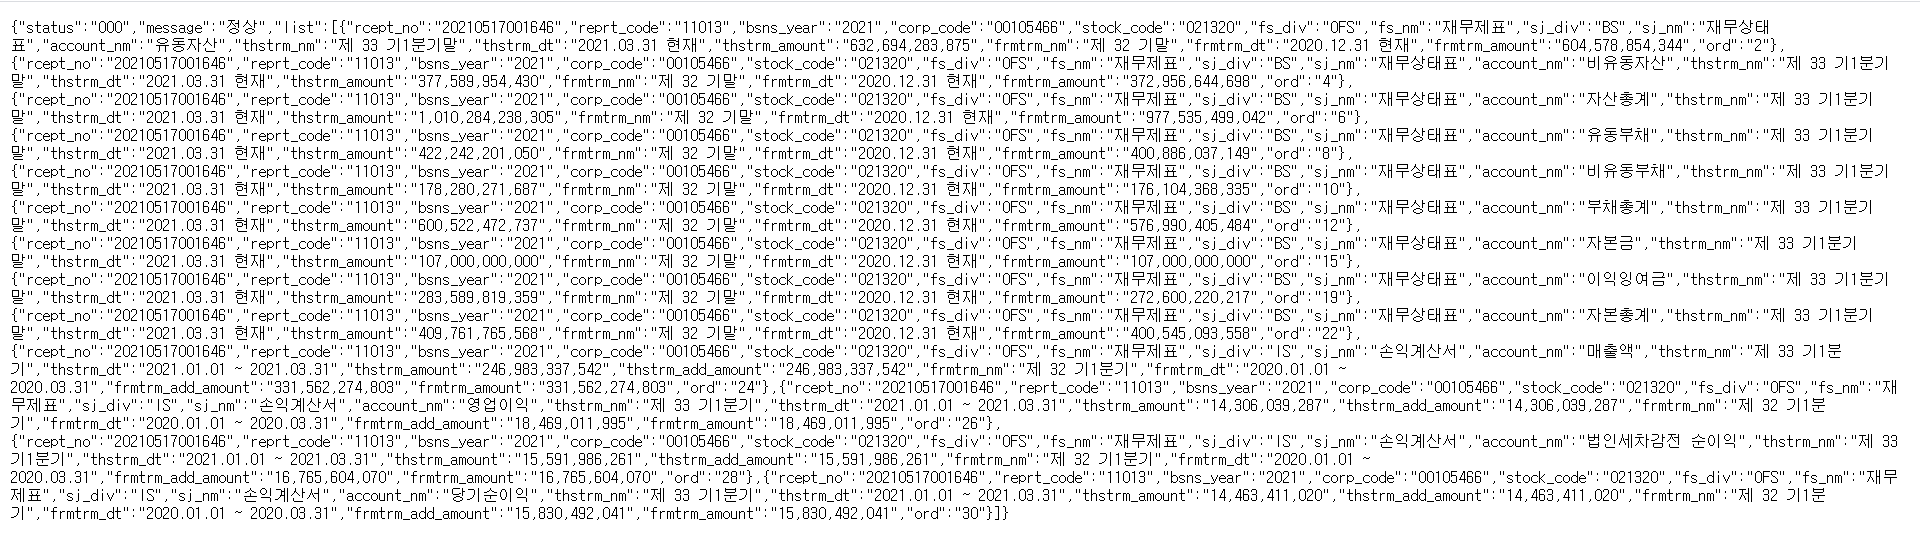

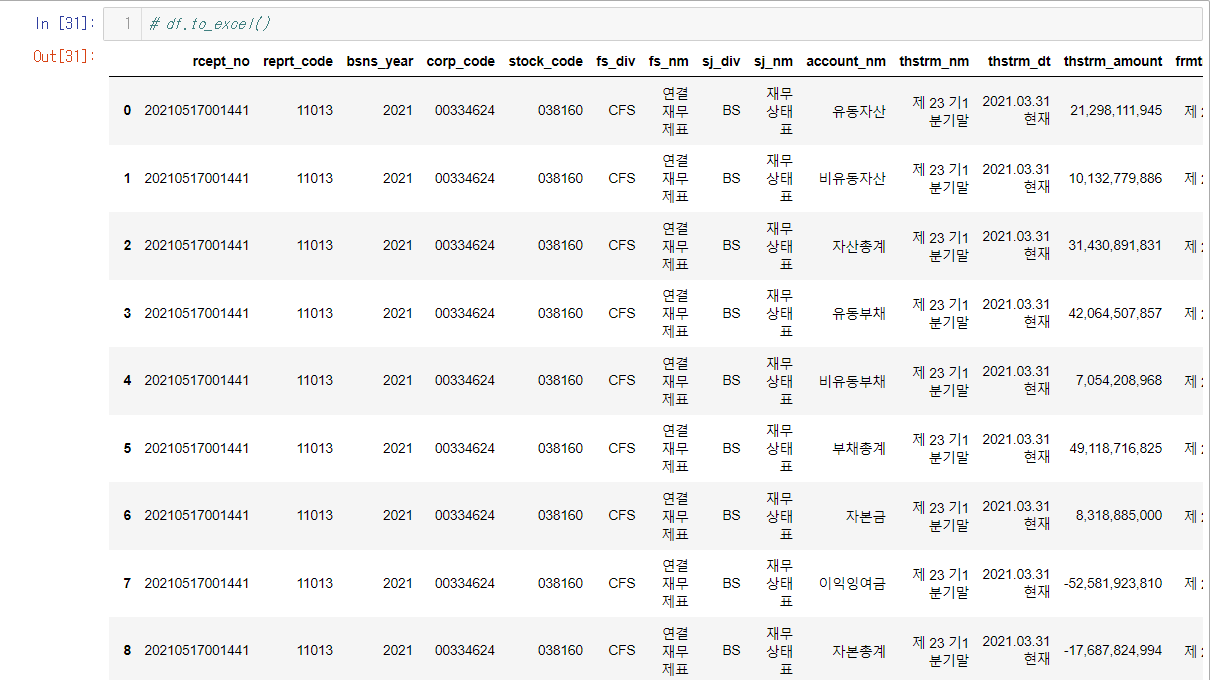

In [5]:
base_url = 'https://opendart.fss.or.kr/api/fnlttMultiAcnt.json' # json파일이 베이스인 각 회사의 재무재표 url을 다트에서 불러옴
crtfc_key = '@@@@' # 각자의 Dart API키를 입력
bsns_year = input("년도수를 입력해 주세요(예시 :2021) : ") # 필요한 재무재표의 년도를 입력


a = input('몇 분기를 원하시나요? 숫자만 입력해주세요(예시 :1/2/3/4) : ') # a와 b는 임의값(잠시 정보를 저장했다가 사라짐)
                                                                  # 1분기/반기/3분기/사업보고서 중에서 하나를 선택하여 입력함
if a == '1' :       # 입력한 분기에 따라 그에 맞는 분기 코드를 if문으로 지정
    b = str(11013)  #1분기 = 11013
elif a == '2' :    
    b = str(11012)  # 반기 = 11012
elif a == '3' :
    b = str(11014)  # 3분기 = 11014
else :
    b = str(11011)  # 사업보고서 = 11011
    
reprt_code = b     # 각 분기에 맞는 코드를 갖고 있는 임의 값(b)를 reprt_code라는 변수에 넣은 후,
                   # reprt_code변수를 최종적으로 json파일을 요청할 url의 분기의 키값을 정함


df_corpcode = pd.read_csv('Dart_codelist_last30_2.csv', usecols = ['종목명','종목코드','기업코드','수정일'],
                          converters={'종목코드':str,'기업코드':str})
#  part 2에서 만든 기업코드 csv파일을 df_corpcode라는 데이터 프레임에 넣어서 사용하기 좋게 만들었음


JM =  pd.DataFrame([], columns = ['종목명','분기','기업코드', '유동자산', '부채총계'])
# part1에서 재무재표라는 최종적으로 만들 데이터 프레임의 틀을 짜줌

if reprt_code[-1] == '3':        # 재무재표에서 사용될 url에서 필요한 키 값인 reprt_code(분기를 구분함)에                             
    quarter = "1분기 보고서"     # 끝에 자릿수에 따라 몇 분기인지 quarter변수에 넣어줌                             
elif reprt_code[-1] == '2' :    # -> 이유는 재무재표 데이터 프레임의 몇분기인지 나타내기 위함 
    quarter ="반기 보고서"
elif reprt_code[-1] == '4' :
    quarter ="3분기 보고서"
else :
    quarter = "사업보고서"

for y in df_corpcode.index: # 인덱스 값으로 기업코드(회사마다 기업코드가 다름) 찾고 그 찾은 기업코드를 후에 request_url로 넣었습니다.
    try:                # 기업코드는 존재하지만 폐지되었거나 아직 재무재표가 json파일로 Dart라는 홈페이지에 올라오지 않는 경우를 거르기 위해서 try 사용
        corp_code_x = df_corpcode['기업코드'][y] #기업코드가 모여있는 데이터 프레임에서 기업코드만 corp_code라는 변수에 넣고 url에 들어갈 키값을 준비해둠
        name = df_corpcode['종목명'][y] #기업코드가 모여있는 데이터 프레임에서 회사이름을 빼서 최정적으로 만들 데이터프레임(==재무제표)에 넣기 위해서 name이라는 변수를 지정

        request_url = base_url + '?' + 'crtfc_key='+crtfc_key+'&corp_code='+corp_code_x+\
        '&bsns_year='+bsns_year + '&reprt_code='+reprt_code        # 앞에서 계속 언급되었던 url을 만들고 요청하기 위한 변수를 만듬. 
                                                                   # 이 url을 이용하여 Dart에 각 회사의 분기별 재무재표 json파일을 요청할 수 있음

        response = requests.get(request_url).content # request_url을 넣어서 열리는 json파일을 요청하는 부분
        data = json.loads(response)     # json 파일 불러옴  
        data = data['list']             # 데이터를 살펴보면, dict 안에 dict가 있는 형태로 안쪽의 list 라는 dict를 꺼내옴 
        df = pd.DataFrame(data)         # 데이터프레임 변환

        
#       문제발생1.  
        if len(df.index) > 13 :                                       # 기업재무제표가 연결재무제표+재무제표일 때, 연결재무제표를 포함한 경우
            temp_Money = int(df['thstrm_amount'][13].replace(',',''))  # 유동자산 값이 나오는 셀에서 ,를 삭제하고 int변환하여 할당
            temp_debt = int(df['thstrm_amount'][18].replace(',',''))  # 부채총계 값에서 ,를 삭제하고 int변환하여 새로운 변수로 할당
        else :                                                        # 그 밖에 연결재무제표는 없고, 재무제표만 있는 경우 
            temp_Money = int(df['thstrm_amount'][0].replace(',',''))  #유동자산을 변수에 넣는 부분
            temp_debt = int(df['thstrm_amount'][5].replace(',',''))   #부채총계를 변수에 넣는 부분
        Money = temp_Money 
        debt = temp_debt
        
        date = bsns_year + '년 ' + quarter # 위에서 할당한 연도, 분기 반영하여 날짜 변수 할당 

        JM =  JM.append({'종목명' :name,'분기' : date, '기업코드' : corp_code_x,'유동자산' : Money,'부채총계' : debt}
                        ,ignore_index=True) #JM(재무재표) 데이터 프레임에 각각의 값을 추가하는 부분입니다!!
    except:
        error_corp = name + ' : '+ corp_code_x  # 재무제표를 불러오는 과정에서 에러나면, 해당 종목명과 기업코드를 프린트. 
        print(error_corp)

JM['청산가치'] = JM['유동자산']-JM['부채총계']  # 기존의 '유동자산'과 '부채총계'의 뺄셈으로 청산가치'를 계산하는 열 생성 


년도수를 입력해 주세요(예시 :2021) : 2021
몇 분기를 원하시나요? 숫자만 입력해주세요(예시 :1/2/3/4) : 1
이큐셀 : 00818472
교보9호스팩 : 01398151
네추럴FNP : 00523176
교보10호기업인수목적 : 01476219
메디안디노스틱 : 01035942
미래에셋맵스리츠 : 01437292
씨앤에스링크 : 01116380
비엔디생활건강 : 01055317
극동전선 : 00105165
CNH : 00149266
세아메탈 : 00206084
삼성카드 : 00126292
흥국화재 : 00103176
인터엠 : 00145914
유진스팩4호 : 01359736
유진스팩5호 : 01393721
이지스레지던스리츠 : 01436628
넥스지 : 00584362
티씨엠생명과학 : 01067242
위월드 : 00663289
한국토지신탁 : 00233653
에이치엔에스하이텍 : 00311216
나눔테크 : 01117422
해원에스티 : 00252001
엘에이티 : 01264234
인카금융서비스 : 01013694
SK6호스팩 : 01414936
다원넥스뷰 : 01344363
루켄테크놀러지스 : 00886792
원바이오젠 : 01138993
파워풀엑스 : 01190780
프로테옴텍 : 01267958
경남은행 : 01030132
삼성증권 : 00104856
나우IB : 00651017
DB손해보험 : 00159102
모보 : 00347442
한국스탠다드차타드은행 : 00148504
케이비증권 : 00164876
한국씨티은행 : 00161444
나우코스 : 00425254
DB금융스팩8호 : 01505450
대신밸런스제9호스팩 : 01508855
DB금융투자 : 00115694
에이펙스인텍 : 00832700
플럼라인생명과학 : 01063237
제노텍 : 00393618
라이프사이언스테크놀로지 : 01187175
펨토바이오메드 : 01336735
파마리서치바이오 : 01066058
티에스엠텍 : 00397243
이노진 : 01419135
한국전기

In [13]:
JM

,종목명,분기,기업코드,유동자산,부채총계,청산가치
0,지놈앤컴퍼니,2021년 1분기 보고서,01276026,99444117279,5760122962,93683994317
1,웹젠,2021년 1분기 보고서,00405320,314276519067,94382174001,219894345066
2,우리넷,2021년 1분기 보고서,00664048,74625085569,37563510513,37061575056
3,마이크로디지탈,2021년 1분기 보고서,01267967,9950472707,10294936016,-344463309
4,나노,2021년 1분기 보고서,00994994,28248401252,27111418730,1136982522
5,손오공,2021년 1분기 보고서,00306870,29146591971,16129794502,13016797469
6,새로닉스,2021년 1분기 보고서,00147994,18118292184,38307850915,-20189558731
7,피씨디렉트,2021년 1분기 보고서,00297934,82359213054,43373420759,38985792295
8,케이엠제약,2021년 1분기 보고서,01095704,12922269436,15139792736,-2217523300
9,로보로보,2021년 1분기 보고서,01063990,14444134397,970676611,13473457786


In [12]:
JM.to_csv("JM_2021_1Q.csv", header=True, index=False, encoding ='utf-8-sig')
# csv파일로 저장, encoding을 위해 'utf-8-sig' 추가 